<a href="https://colab.research.google.com/github/conwayjw97/Image-Colourisation-with-Deep-Learning/blob/master/src/CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Select your Dataset

In [0]:
# Insert an integer value for the DATASET_CHOICE variable below
# 0 = Symbol Set
# 1 = cifar10 (You can also choose a class with CIFAR10_CLASS)
# 2 = Celeb faces
# 3 = ImageNette
DATASET_CHOICE = 1
# If you wish to use a specific cifar10 class, specify one here, otherwise assign the variable to None
CIFAR10_CLASS = 6

# Define Global Parameters


In [0]:
BATCH_SIZE = 100
LATENT_DIM = 128
EPOCHS = 500

# Library Imports

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import tensorflow as tf

from scipy.stats import norm
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Lambda, Reshape, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import backend as K
from skimage import io
from skimage.transform import resize

# Dataset Setup

In [0]:
# TODO: ADD THE OTHER DATASETS AND DECIDE ON GITHUB OR DRIVE FOR HOSTING
# TODO: FIX THE GRAYSCALE CONVERSION FOR THE SYMBOL SET
if(DATASET_CHOICE == 0):
  from google.colab import drive, files
  drive.mount("/content/gdrive", force_remount=True)
  !unzip -uq "/content/gdrive/My Drive/Dissertation/Data/SymbolSet/SymbolSet.zip" -d "/content/gdrive/My Drive/Dissertation/Data/SymbolSet/" 
  base_dir = "/content/gdrive/My Drive/Dissertation/Data/SymbolSet/Symbol Set"

  images = []
  for image in io.imread_collection(base_dir + "/*.jpg"): 
    image = np.array(resize(image, (128, 128)))
    if(image.shape == (128, 128, 3)):
      images.append(image)
  train_images = np.array(images[1:-1:2])
  test_images = np.array(images[0:-2:2])

  output_count = 9
  index_offset = 0

elif(DATASET_CHOICE == 1):
  (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
  train_images = train_images / 255.0
  test_images = test_images / 255.0

  if(CIFAR10_CLASS is not None):
    class_train_indices = np.argwhere(train_labels == CIFAR10_CLASS)
    train_images = train_images[class_train_indices[:,0]]
    class_test_indices = np.argwhere(test_labels == CIFAR10_CLASS)
    test_images = test_images[class_test_indices[:,0]]

  output_count = 12
  index_offset = 20

train_yuv  = tf.image.rgb_to_yuv(train_images)
train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
train_uv = train_yuv[:,:,:,1:]

test_yuv = tf.image.rgb_to_yuv(test_images)
test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
test_uv = test_yuv[:,:,:,1:]

In [0]:
# https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder_deconv.py
# https://xiangyutang2.github.io/auto-colorization-autoencoders/

# Sampling with the reparametrisation trick
def sample(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(z_log_var / 2) * epsilon

def slice_y(args):
    yuv_image = args
    return yuv_image[:,:,:,0]

def slice_uv(args):
    yuv_image = args
    return yuv_image[:,:,:,1:]

yuv_in = Input(shape=(train_yuv.shape[1], train_yuv.shape[2], train_yuv.shape[3]))
y_in = Input(shape=(train_y.shape[1], train_y.shape[2], train_y.shape[3]))
# uv = Lambda(slice_uv, output_shape=(train_yuv.shape[1], train_yuv.shape[2], 2))(yuv_in)

# Define Training Encoder q(z|yuv)
layer = Conv2D(filters=8, kernel_size=3, activation='relu', strides=2, padding='same')(yuv_in)
layer = Conv2D(filters=16, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2D(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2D(filters=128, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
shape = K.int_shape(layer) # Shape before flattening

# Latent space for encoder
layer = Flatten()(layer)
layer = Dense(512, activation='relu')(layer)
z_mean_training = Dense(LATENT_DIM)(layer)
z_log_var_training = Dense(LATENT_DIM)(layer)
z_training = Lambda(sample, output_shape=(LATENT_DIM,))([z_mean_training, z_log_var_training]) # Data passable to the decoder

# Instantiate encoder 
encoder_training = Model(yuv_in, z_training, name='training_encoder')
encoder_training.summary()

Model: "training_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 16, 16, 8)    224         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 8, 8, 16)     1168        conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 4, 4, 64)     9280        conv2d_9[0][0]                   
___________________________________________________________________________________

In [0]:
# Define Conditional Encoder p(z|y)
layer = Conv2D(filters=8, kernel_size=3, activation='relu', strides=2, padding='same')(y_in)
layer = Conv2D(filters=16, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2D(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2D(filters=128, kernel_size=3, activation='relu', strides=2, padding='same')(layer)

# Latent space for conditional encoder
layer = Flatten()(layer)
layer = Dense(512, activation='relu')(layer)
z_mean_conditional = Dense(LATENT_DIM)(layer)
z_log_var_conditional = Dense(LATENT_DIM)(layer)
z_conditional = Lambda(sample, output_shape=(LATENT_DIM,))([z_mean_conditional, z_log_var_conditional]) # Data passable to the decoder

# Instantiate conditional encoder
encoder_conditional = Model(y_in, z_conditional, name='conditional_encoder')
encoder_conditional.summary()

Model: "conditional_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 16, 16, 8)    80          input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 8, 8, 16)     1168        conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 4, 4, 64)     9280        conv2d_13[0][0]                  
________________________________________________________________________________

In [0]:
# Define Decoder p(yuv|z,y)
latent_inputs = Input(shape=(LATENT_DIM,))
layer = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
layer = Reshape((shape[1], shape[2], shape[3]))(layer)
layer = Conv2DTranspose(filters=128, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2DTranspose(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2DTranspose(filters=16, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2DTranspose(filters=8, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
uv_out = Conv2DTranspose(filters=2, kernel_size=3, activation='tanh', padding='same')(layer)
concat_outputs = concatenate([uv_out, y_in], 3)
layer = Conv2DTranspose(filters=8, kernel_size=3, activation='relu', padding='same')(concat_outputs)
yuv_out = Conv2DTranspose(filters=3, kernel_size=3, activation='tanh', padding='same')(layer)

# Instantiate Decoder
decoder = Model([latent_inputs, y_in], yuv_out, name='decoder')
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          66048       input_6[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 2, 2, 128)    0           dense_13[0][0]                   
__________________________________________________________________________________________________
conv2d_transpose_8 (Conv2DTrans (None, 4, 4, 128)    147584      reshape_1[0][0]                  
____________________________________________________________________________________________

In [0]:
# Instantiate training VAE
training_yuv_out = decoder([z_training, y_in])
training_vae = Model([yuv_in, y_in], training_yuv_out, name='training_vae')
training_vae.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_5:0
Model: "training_vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 16, 16, 8)    224         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 8, 8, 16)     1168        conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 4, 4, 64)     9280  

In [0]:
# TODO: CLEAN UP THIS LOSS FUNCTION AND FIND A SUITABLE SIZE FOR RECONSTRUCTION
reconstruction_loss = K.sum(mse(yuv_in, training_yuv_out))
reconstruction_loss *= (train_yuv.shape[1] * train_yuv.shape[2]) # Everything turns out orange if you don't upscale the reconstruction
# kl_loss = 1 + z_log_var_training - K.square(z_mean_training) - K.exp(z_log_var_training)
# kl_loss = K.sum(kl_loss, axis=-1)
# kl_loss *= -0.5


# # COST FROM RECONSTRUCTION
# SMALL_CONSTANT = 1e-6
# normalising_factor_uv_vae = - 0.5 * K.log(SMALL_CONSTANT+K.exp(log_sig_sqr_yuv)) - 0.5 * K.log(2 * np.pi)
# square_diff_between_mu_and_yuv_vae = K.square(mean_yuv - yuv_in) # yuv_in???
# inside_exp_x_vae = -0.5 * (square_diff_between_mu_and_yuv_vae / (SMALL_CONSTANT+K.exp(log_sig_sqr_yuv)))
# reconstr_loss_x_vae = -K.sum(normalising_factor_uv_vae + inside_exp_x_vae, 1)
# cost_R_vae = K.mean(reconstr_loss_x_vae)

# KL(q(z|uv,y)||p(z|y))
SMALL_CONSTANT = 1e-6
v_mean = z_mean_conditional #2
aux_mean = z_mean_training #1
v_log_sig_sq = K.log(K.exp(z_log_var_conditional)+SMALL_CONSTANT) #2
aux_log_sig_sq = K.log(K.exp(z_log_var_training)+SMALL_CONSTANT) #1
v_log_sig = K.log(K.sqrt(K.exp(v_log_sig_sq))) #2
aux_log_sig = K.log(K.sqrt(K.exp(aux_log_sig_sq))) #1
cost_VAE_a = v_log_sig-aux_log_sig+((K.exp(aux_log_sig_sq)+K.square(aux_mean-v_mean))/(2*K.exp(v_log_sig_sq)))-0.5
cost_VAE_b = K.sum(cost_VAE_a,1)
KL_vae = K.mean(cost_VAE_b)

conditional_loss = K.sum(mse(z_training, z_conditional))
training_loss = K.mean(reconstruction_loss + KL_vae + conditional_loss)

training_vae.add_loss(training_loss)

training_vae.compile(optimizer='adam')

In [0]:
# Training VAE fitting
history = training_vae.fit([train_yuv, train_y], shuffle=False, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=([test_yuv, test_y], None))

Train on 5000 samples, validate on 1000 samples
Epoch 1/500
5000/5000 [==============================] - 2s 393us/sample - loss: 2399962.4025 - val_loss: 858923.8375
Epoch 2/500
5000/5000 [==============================] - 1s 120us/sample - loss: 706988.3087 - val_loss: 597951.4187
Epoch 3/500
5000/5000 [==============================] - 1s 138us/sample - loss: 519965.2850 - val_loss: 458112.2875
Epoch 4/500
5000/5000 [==============================] - 1s 122us/sample - loss: 398000.5894 - val_loss: 357063.2844
Epoch 5/500
5000/5000 [==============================] - 1s 116us/sample - loss: 320102.9231 - val_loss: 294387.8969
Epoch 6/500
5000/5000 [==============================] - 1s 119us/sample - loss: 270712.9294 - val_loss: 254836.1109
Epoch 7/500
5000/5000 [==============================] - 1s 116us/sample - loss: 237283.0903 - val_loss: 226048.8047
Epoch 8/500
5000/5000 [==============================] - 1s 118us/sample - loss: 214502.9678 - val_loss: 208292.2047
Epoch 9/500
500

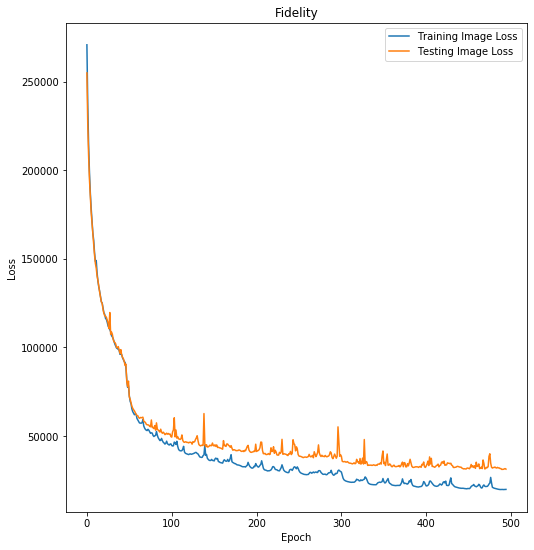

In [0]:
fig = plt.figure(figsize=(38, 9))

fig.add_subplot(1,4,1)
plt.title("Fidelity")
plt.plot(history.history["loss"][5:], label="Training Image Loss")
plt.plot(history.history["val_loss"][5:], label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


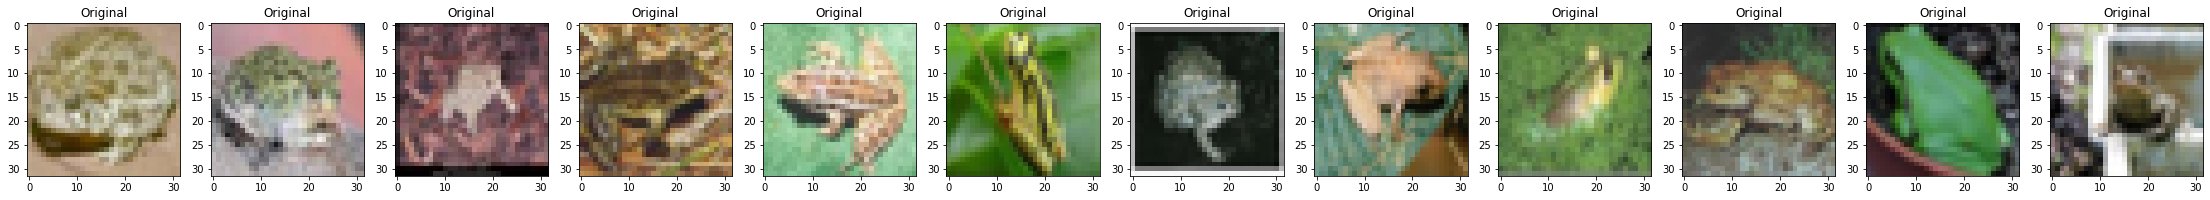

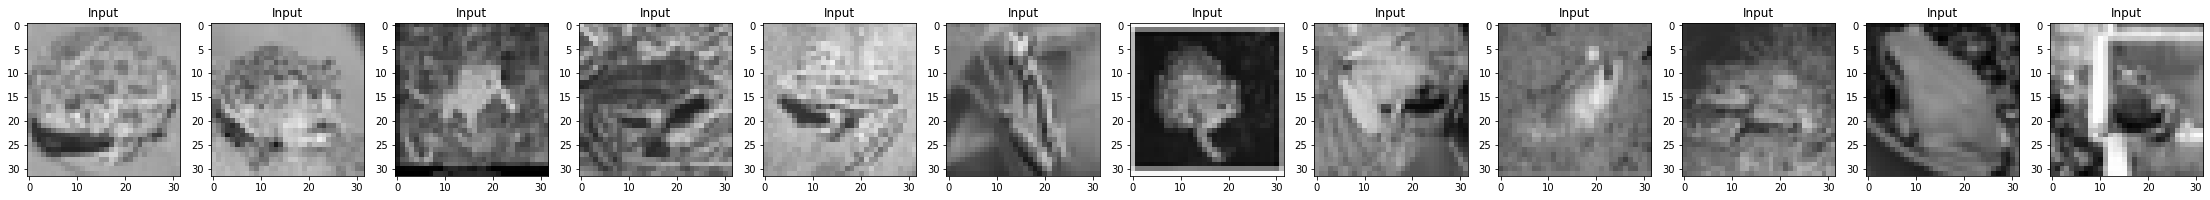

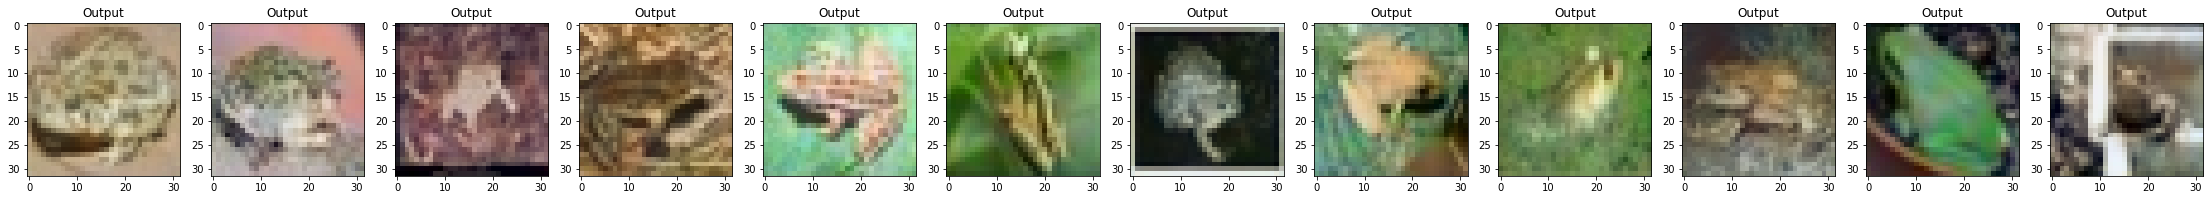

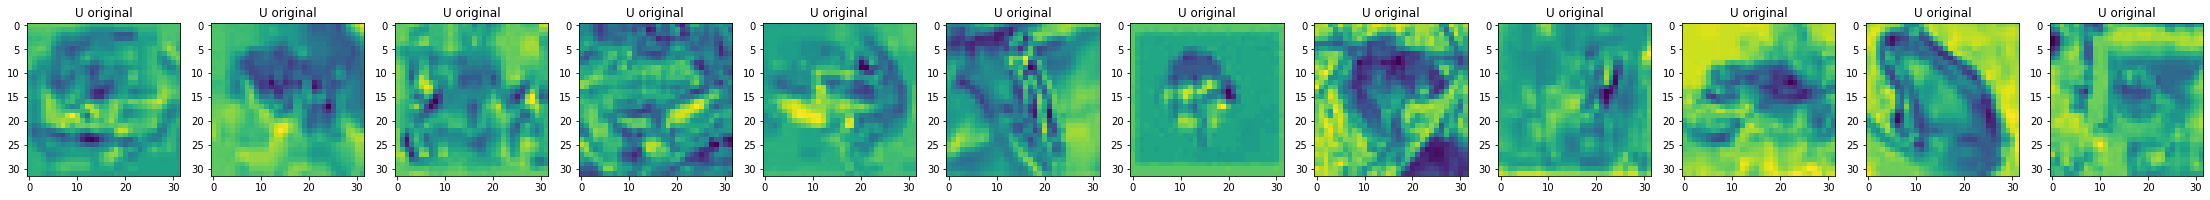

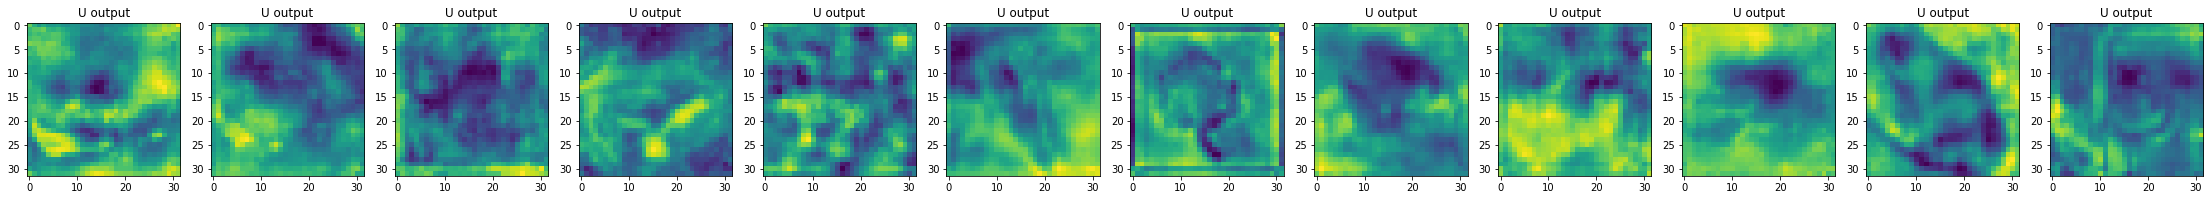

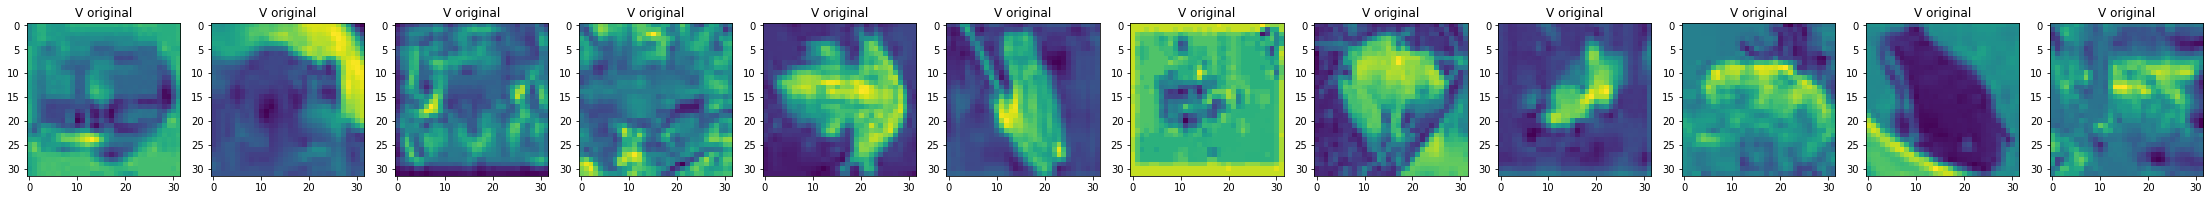

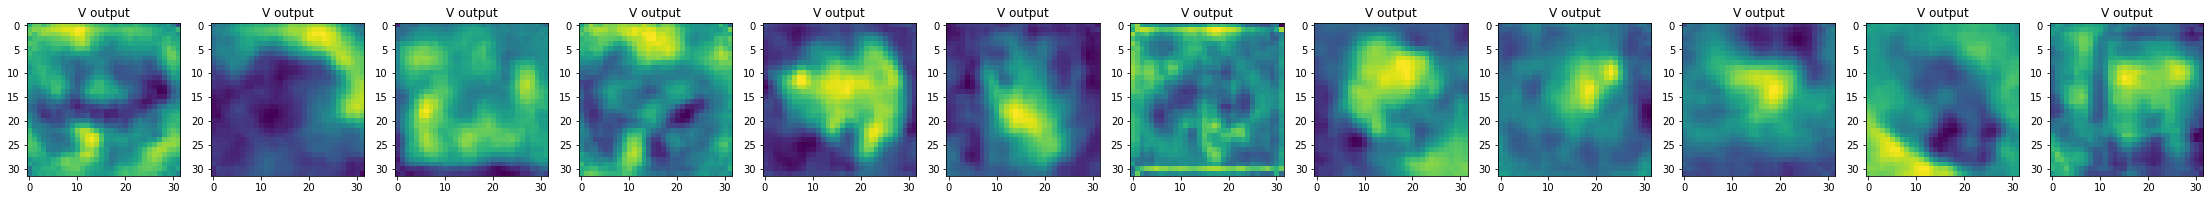

In [0]:
umap = LinearSegmentedColormap.from_list('mycmap', ['blue', 'green'])
vmap = LinearSegmentedColormap.from_list('mycmap', ['red', 'yellow'])

sample_z = encoder_conditional.predict(train_y)
result = decoder.predict([sample_z, train_y])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(train_images[i+index_offset])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Input")
  plt.imshow(tf.image.grayscale_to_rgb(train_y[i+index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[i+index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(train_yuv[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(train_yuv[i+index_offset,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[i+index_offset,:,:,2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


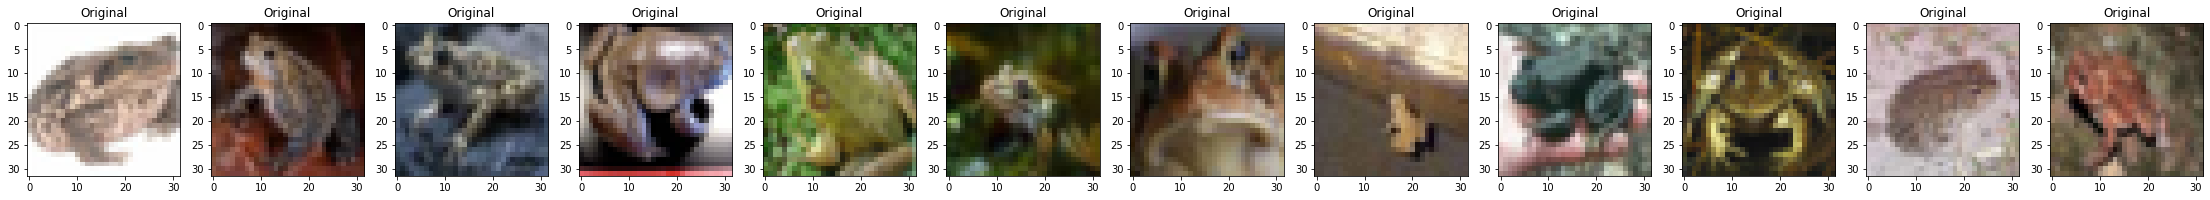

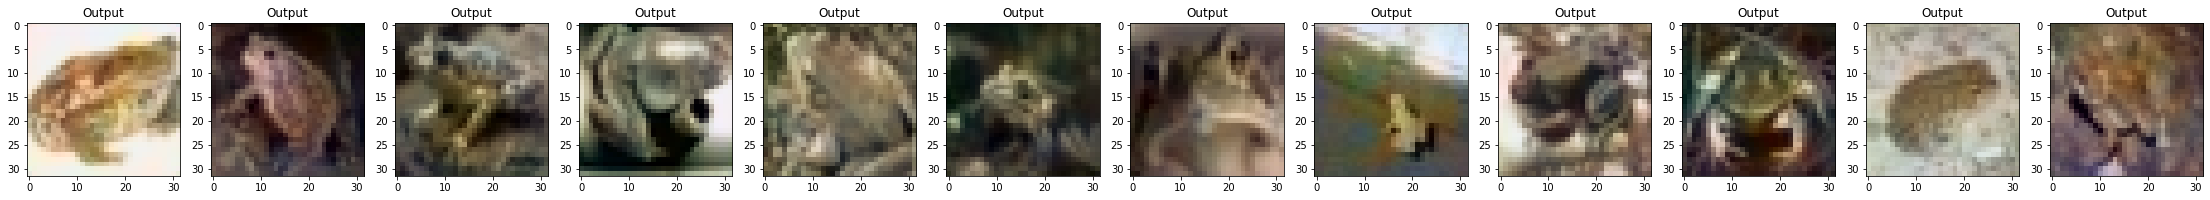

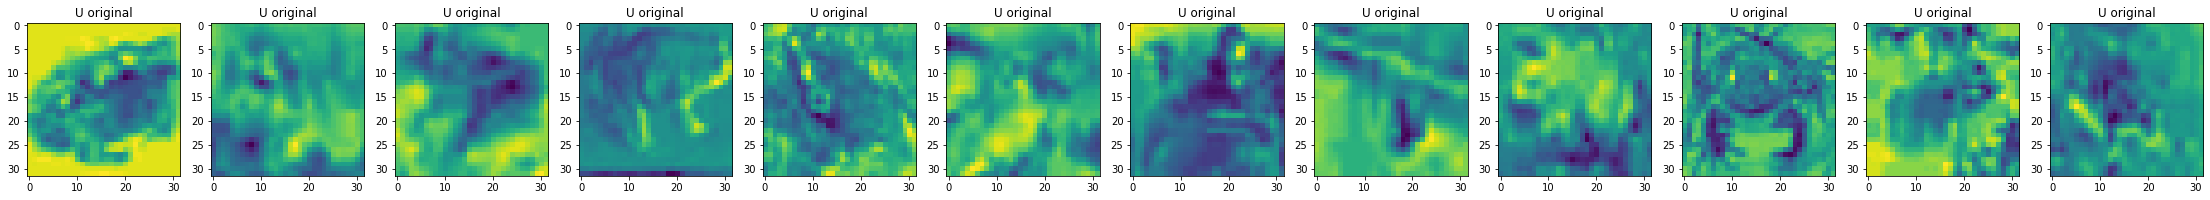

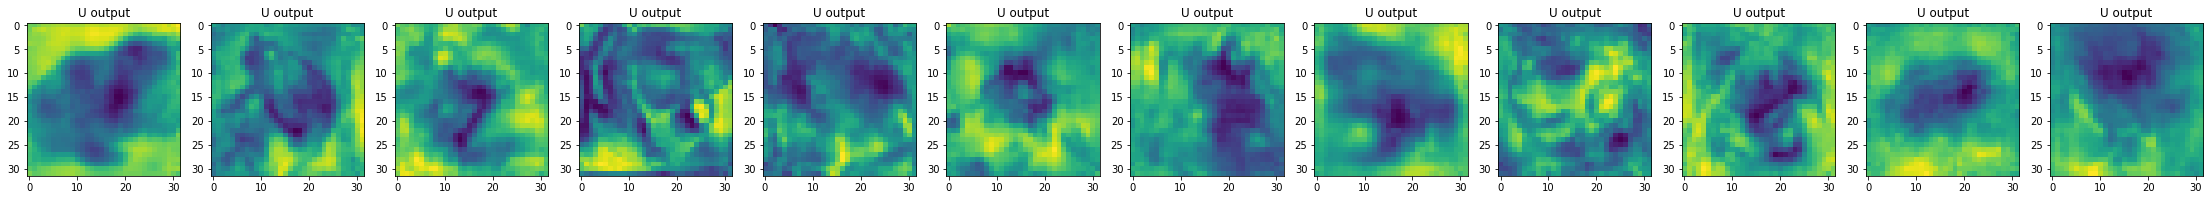

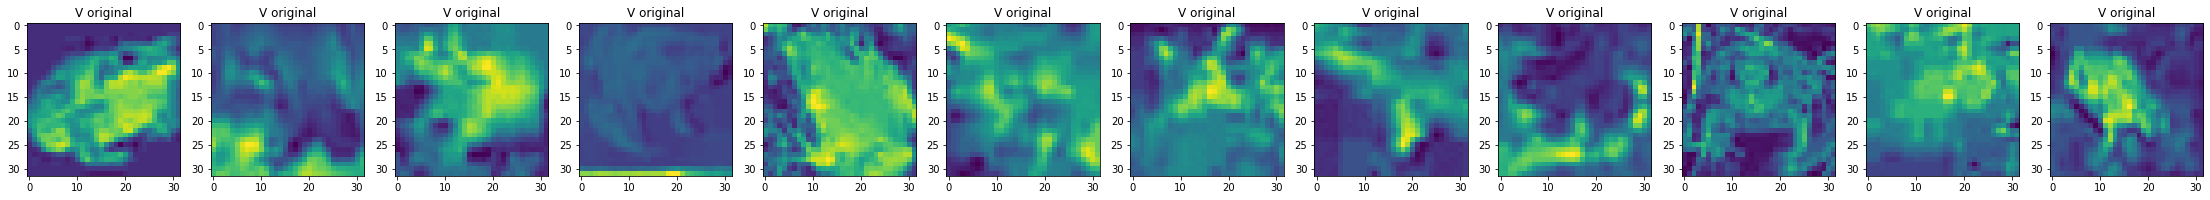

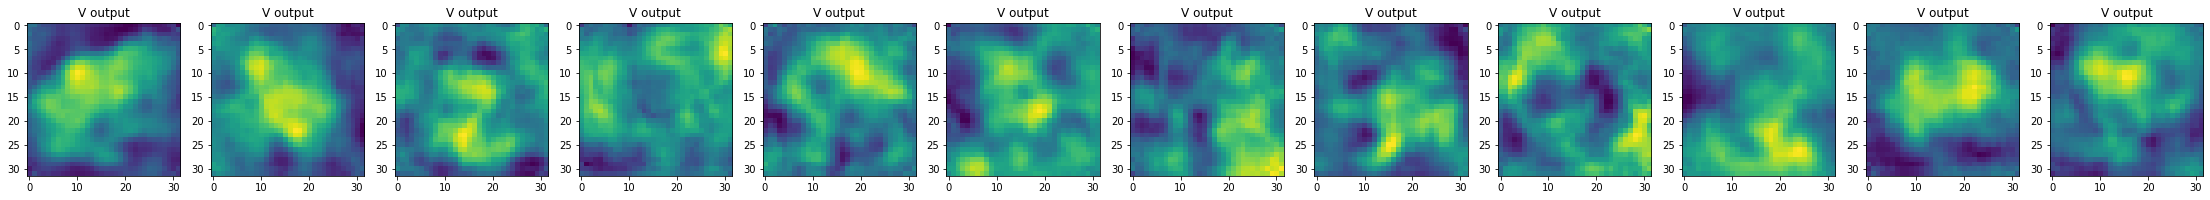

In [0]:
sample_z = encoder_conditional.predict(test_y)
result = decoder.predict([sample_z, test_y])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(test_images[i+index_offset])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[i+index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(test_yuv[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(test_yuv[i+index_offset,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[i+index_offset,:,:,2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

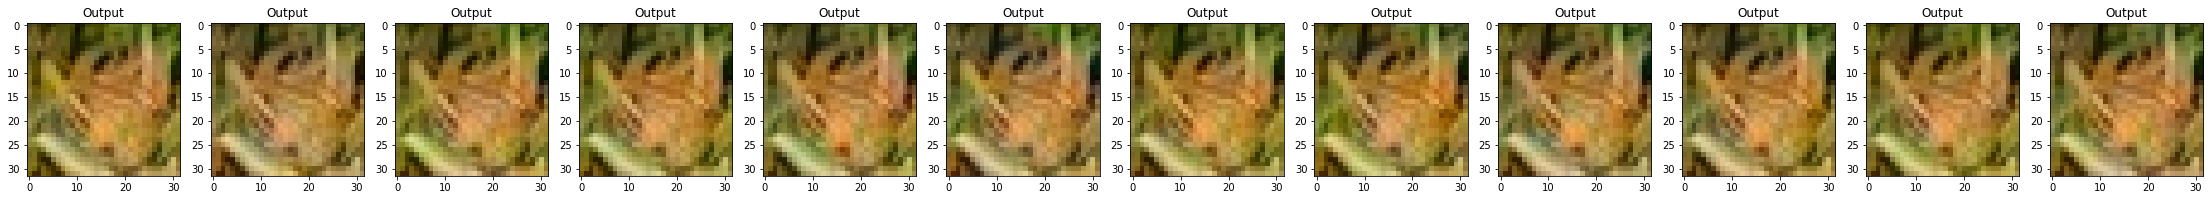

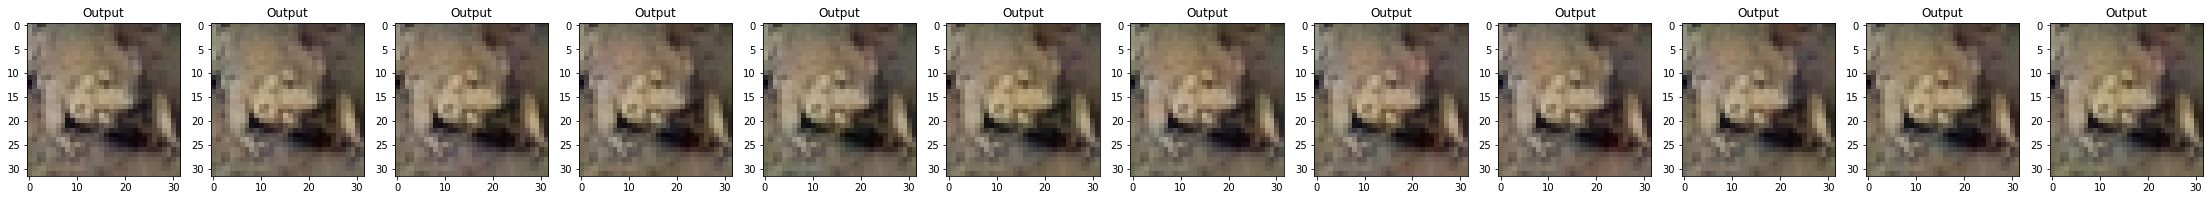

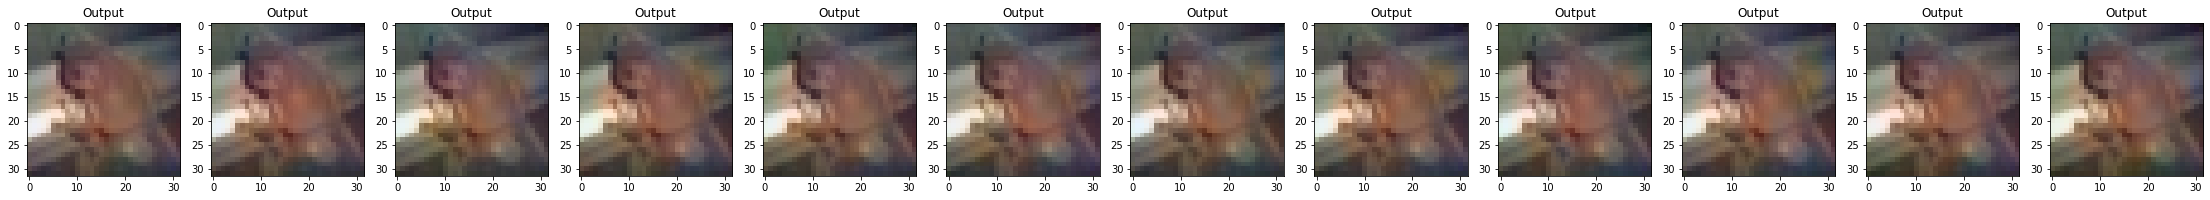

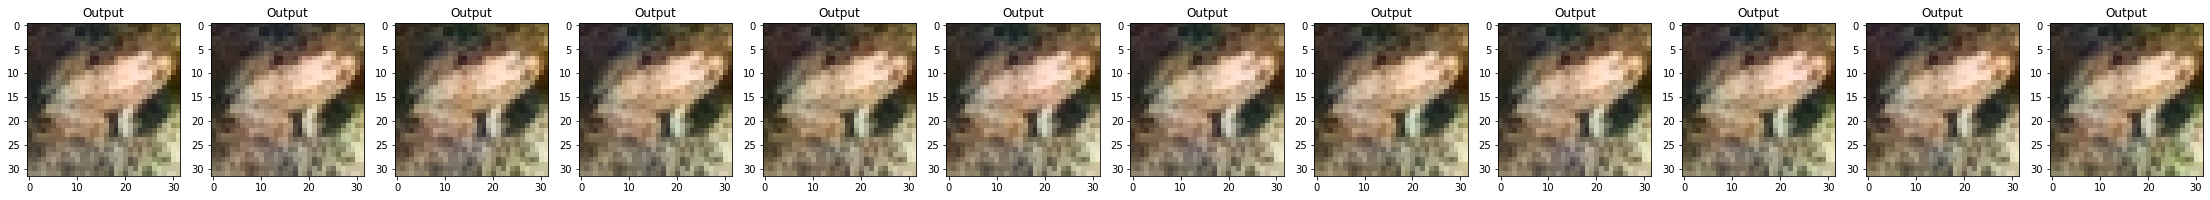

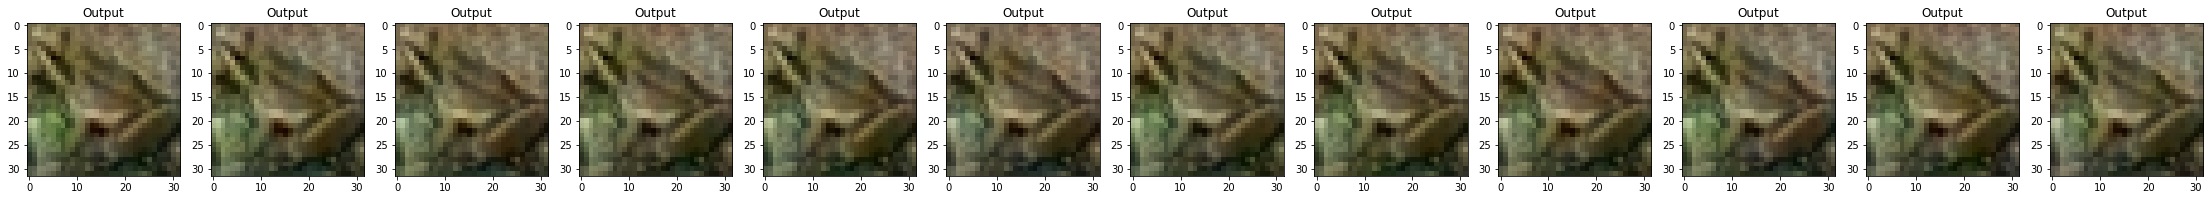

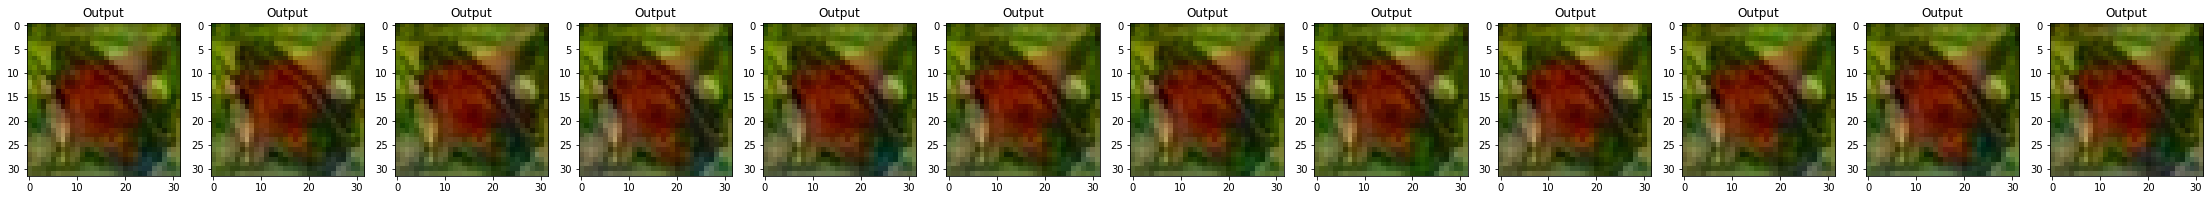

In [0]:
# TODO: GET RID OF THESE INPUT CLIPPING MESSAGE
output_count = 12
index_offset = 0

diverse_colourisations = []
for i in range(output_count):
  sample_z = encoder_conditional.predict(test_y)
  result = decoder.predict([sample_z, test_y])
  diverse_colourisations.append(result)

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  sample_z = encoder_conditional.predict(test_y)
  result = decoder.predict([sample_z, test_y])
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(diverse_colourisations[i][index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  sample_z = encoder_conditional.predict(test_y)
  result = decoder.predict([sample_z, test_y])
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(diverse_colourisations[i][index_offset+1]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  sample_z = encoder_conditional.predict(test_y)
  result = decoder.predict([sample_z, test_y])
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(diverse_colourisations[i][index_offset+2]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  sample_z = encoder_conditional.predict(test_y)
  result = decoder.predict([sample_z, test_y])
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(diverse_colourisations[i][index_offset+3]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  sample_z = encoder_conditional.predict(test_y)
  result = decoder.predict([sample_z, test_y])
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(diverse_colourisations[i][index_offset+4]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  sample_z = encoder_conditional.predict(test_y)
  result = decoder.predict([sample_z, test_y])
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(diverse_colourisations[i][index_offset+5]))